In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('downPackets.csv', sep= ";")

In [3]:
df.head()

,id,imme,tmst,tmms,freq,rfch,powe,modu,datr,codr,fdev,ipol,prea,size,data,ncrc
0,1,0,1729162410,Nan,868.3,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,33,IB9CLTWIvANzFRobSHpfDItCRiVKLq7ZBuDwrAXT8Uk+,1
1,2,0,1729162418,Nan,867.9,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAAADUP8AAQYBWQxO,1
2,3,0,1729162436,Nan,868.3,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAQADUf8AAQYnNE+f,1
3,4,0,1729162454,Nan,868.1,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAgADUf8AAQb82c+D,1
4,5,0,1729162472,Nan,868.3,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAwADUf8AAQZbuxCb,1


In [4]:
df.shape

(503, 16)

### Decoding Data Column

In [5]:
import base64
from pprint import pprint

def decode_lorawan_packet(base64_packet):
    try:
        # Decode the base64 packet into bytes
        packet_bytes = base64.b64decode(base64_packet)

        # Initialize an empty dictionary to store packet components
        packet_dict = {}

        # Extracting the MHDR (Message Header)
        packet_dict['MHDR'] = packet_bytes[0]
        packet_dict['MType'] = (packet_bytes[0] >> 5) & 0x07
        packet_dict['RFU'] = (packet_bytes[0] >> 2) & 0x07
        packet_dict['Major'] = packet_bytes[0] & 0x03

        # Extract DevAddr (4 bytes, little-endian)
        devaddr_bytes = packet_bytes[1:5]
        packet_dict['DevAddr'] = devaddr_bytes[::-1].hex()

        # FCtrl (Frame Control)
        packet_dict['FCtrl'] = packet_bytes[5]

        # FCnt (Frame Counter, 2 bytes, little-endian)
        fcnt_bytes = packet_bytes[6:8]
        packet_dict['FCnt'] = int.from_bytes(fcnt_bytes, byteorder='little')

        # Optional FOpts (Frame Options), its length depends on the lower 4 bits of FCtrl
        fopts_length = packet_dict['FCtrl'] & 0x0F
        fopts_end = 8 + fopts_length
        packet_dict['FOpts'] = packet_bytes[8:fopts_end].hex() if fopts_length > 0 else None

        # FPort (1 byte after FOpts, if present)
        if len(packet_bytes) > fopts_end:
            packet_dict['FPort'] = packet_bytes[fopts_end]
            fopts_end += 1
        else:
            packet_dict['FPort'] = None

        # FRMPayload (remaining bytes after FPort)
        if len(packet_bytes) > fopts_end:
            packet_dict['FRMPayload'] = packet_bytes[fopts_end:].hex()
        else:
            packet_dict['FRMPayload'] = None

        return packet_dict
    except:
        return None

In [6]:
decoded_df = df["data"].apply(decode_lorawan_packet).apply(pd.Series)

df = pd.concat([df.drop(columns=["data"]), decoded_df], axis=1)

In [7]:
df.head()

,id,imme,tmst,tmms,freq,rfch,powe,modu,datr,codr,...,MHDR,MType,RFU,Major,DevAddr,FCtrl,FCnt,FOpts,FPort,FRMPayload
0,1,0,1729162410,Nan,868.3,0,14,LORA,SF9BW125,4/5,...,32,1,0,0,352d421f,136,956,73151a1b487a5f0c,139,4246254a2eaed906e0f0ac05d3f1493e
1,2,0,1729162418,Nan,867.9,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,0,0350ff000106,1,590c4e
2,3,0,1729162436,Nan,868.3,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,1,0351ff000106,39,344f9f
3,4,0,1729162454,Nan,868.1,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,2,0351ff000106,252,d9cf83
4,5,0,1729162472,Nan,868.3,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,3,0351ff000106,91,bb109b


In [8]:
df.columns

Index(['id', 'imme', 'tmst', 'tmms', 'freq', 'rfch', 'powe', 'modu', 'datr',
       'codr', 'fdev', 'ipol', 'prea', 'size', 'ncrc', 'MHDR', 'MType', 'RFU',
       'Major', 'DevAddr', 'FCtrl', 'FCnt', 'FOpts', 'FPort', 'FRMPayload'],
      dtype='object')

In [9]:
df.shape

(503, 25)

In [10]:
df.duplicated().sum() #No duplicate rows

0

In [11]:
len(df["DevAddr"].unique()) #208 end devices

208

In [12]:
# Show count of NaNs per column
nan_counts = df.isna().sum()

# Display only columns with at least one NaN
print(nan_counts[nan_counts > 0])

FOpts    139
dtype: int64


In [15]:
df_valid_packets = df[df['FRMPayload'].notnull()]

#FPort Analysis

In [16]:
df_valid_packets["FPort"].unique()

array([139,   1,  39, 252,  91, 165, 253, 202, 133,  82, 228, 222,   0,
       159, 119,  97, 162,  16, 245,  65, 104, 194, 153,  54, 198,  52,
       106, 163, 137, 240, 157, 192, 237, 220, 195, 134, 178, 124, 255,
       123, 102, 111, 126, 127, 227, 236, 196,  45, 211,  49, 224,  17,
        75,  47, 241, 128, 108, 112, 193, 107,  32, 176, 201,  24,  64,
       147,  21, 148,  27, 248, 205,  48,   4, 138, 189,  74, 254, 238,
       180,  18, 229, 151, 174, 199,  10, 204, 234,  33,  58,  31,  34,
        23, 231,  37,  87, 181,  46,  42, 218, 144,  25, 225, 158, 117,
       203, 164, 186,   7,   5, 213,  35, 242,  26, 207, 184, 217,  89,
        67, 105, 249, 118, 209,  55,  96, 120,  71,  88,  28, 190, 113,
        98,  30,  77,  59,  81,  93, 169, 101, 251, 142,  62,  11, 175,
        53,  22, 146,  14, 150, 191, 182, 216,   6, 145, 152, 185, 114,
       143,  69,  19, 140,  94, 121, 135, 215, 154,  86,  29, 188,   8,
       110, 130, 149, 166,   3,  51, 214, 161,  40,  76,  63,   

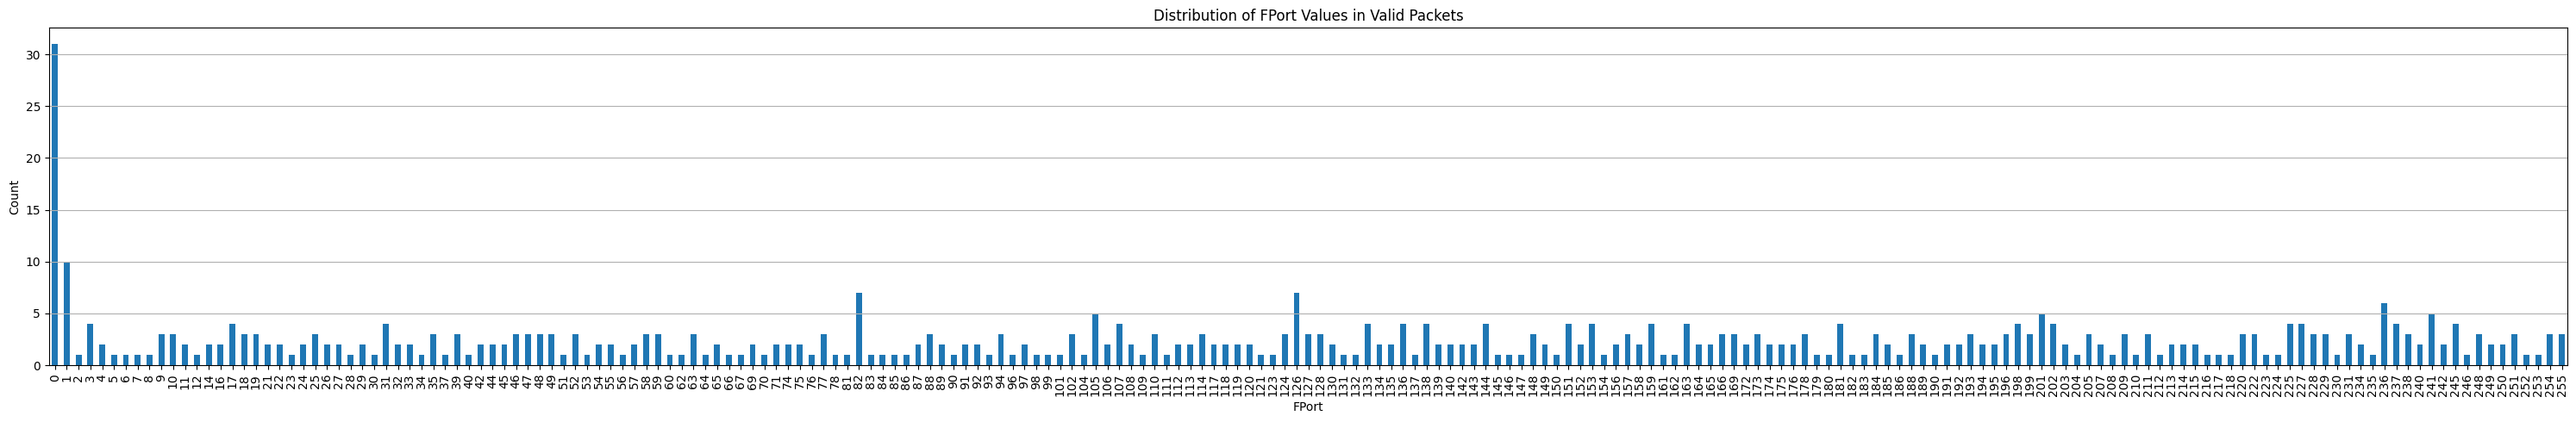

In [17]:
# Create a histogram (bar chart) of the FPort column
fport_counts = df_valid_packets["FPort"].value_counts().sort_index()

plt.figure(figsize=(30, 5))
fport_counts.plot(kind='bar')
plt.xlabel("FPort")
plt.ylabel("Count")
plt.title("Distribution of FPort Values in Valid Packets")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [18]:
# Count FPort occurrences
fport_counts = df_valid_packets["FPort"].value_counts()

# Identify FPorts in the 244–255 range (Special Use)
special_use_fports = fport_counts[fport_counts.index >= 244]
special_use_sum = special_use_fports.sum()

# Remove special use FPorts from the main counts temporarily
fport_counts_cleaned = fport_counts.drop(special_use_fports.index, errors='ignore')

# Get the top 6 FPorts from the cleaned counts
top_6 = fport_counts_cleaned.head(6)

# Remove those top 6 from cleaned to find the rest (Others)
remaining_fports = fport_counts_cleaned.drop(top_6.index, errors='ignore')
others_sum = remaining_fports.sum()

# Combine all into final Series
final_series = pd.concat([
    top_6,
    pd.Series({'Special Use': special_use_sum}),
    pd.Series({'Others': others_sum})
])

# Convert to lists
labels = final_series.index.tolist()
values = final_series.values.tolist()

# Plot
fig = go.Figure(data=[
    go.Pie(labels=labels, values=values, pull=[0, 0.2, 0, 0, 0, 0, 0, 0], textinfo='label+percent')
])

fig.update_layout(
    title=dict(
        text="FPort Distribution for Valid Packets",
        font=dict(size=24),
        x=0.5,
        xanchor='center'
    ),
    legend_title="FPorts",
    legend=dict(font=dict(size=14)),
    width=800,
    height=600
)

fig.show()

FPort_category
Application    405
Reserved        67
Control         31
Name: count, dtype: int64


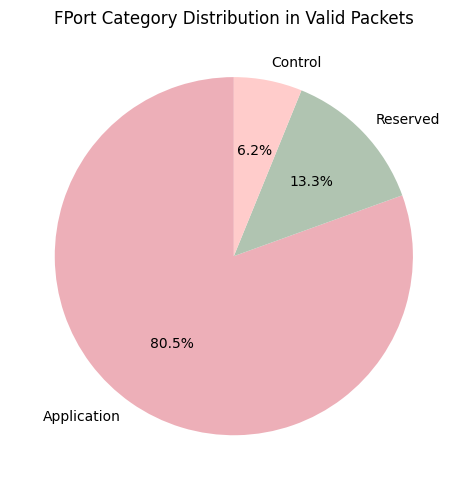

In [19]:
# Filter only packets with valid payload
valid_packets = df[df['FRMPayload'].notnull()]

# Function to categorize FPort values
def categorize_fport(fport):
    if fport == 0:
        return 'Control'
    elif 1 <= fport <= 223:
        return 'Application'
    elif 224 <= fport <= 255:
        return 'Reserved'
    else:
        return 'Unknown'

# Apply categorization to create a new column
valid_packets['FPort_category'] = valid_packets['FPort'].apply(categorize_fport)

# Count the number of packets in each category
category_counts = valid_packets['FPort_category'].value_counts()

print(category_counts)

# Optional: Plot the distribution as a pie chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#edafb8', '#b0c4b1', '#ffcccb'])
plt.title('FPort Category Distribution in Valid Packets')
plt.ylabel('')  # Remove the default label
plt.tight_layout()
plt.show()


# Device Count by Number of Packets Sent

Maximum number of packets sent by a device: 57


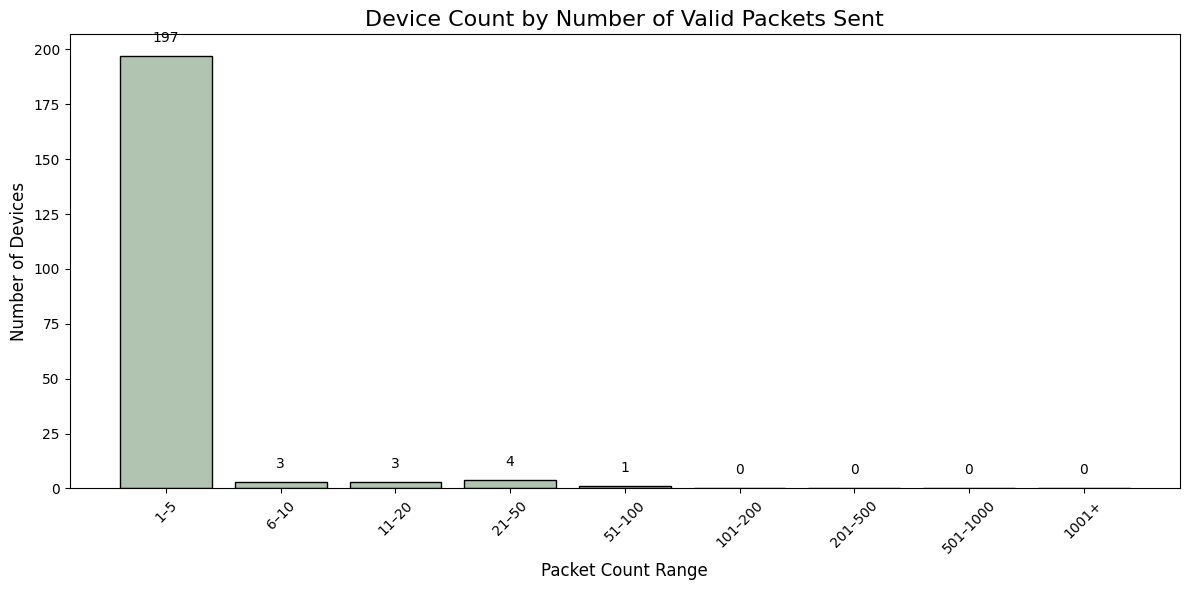

In [20]:
# Count how many packets per DevAddr
devaddr_counts = df_valid_packets['DevAddr'].value_counts()
print("Maximum number of packets sent by a device:", devaddr_counts.max())
# Define bins and labels
bins = [1, 6, 11, 21, 51, 101, 201, 501, 1001, float('inf')]
labels = ['1–5', '6–10', '11–20', '21–50', '51–100', '101–200', '201–500', '501–1000', '1001+']

# Bin the device packet counts
binned = pd.cut(devaddr_counts, bins=bins, labels=labels, right=False)
binned_counts = binned.value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(binned_counts.index.astype(str), binned_counts.values, edgecolor='black', color='#b0c4b1')
plt.title('Device Count by Number of Valid Packets Sent', fontsize=16)
plt.xlabel('Packet Count Range', fontsize=12)
plt.ylabel('Number of Devices', fontsize=12)
plt.xticks(rotation=45)

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        str(height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

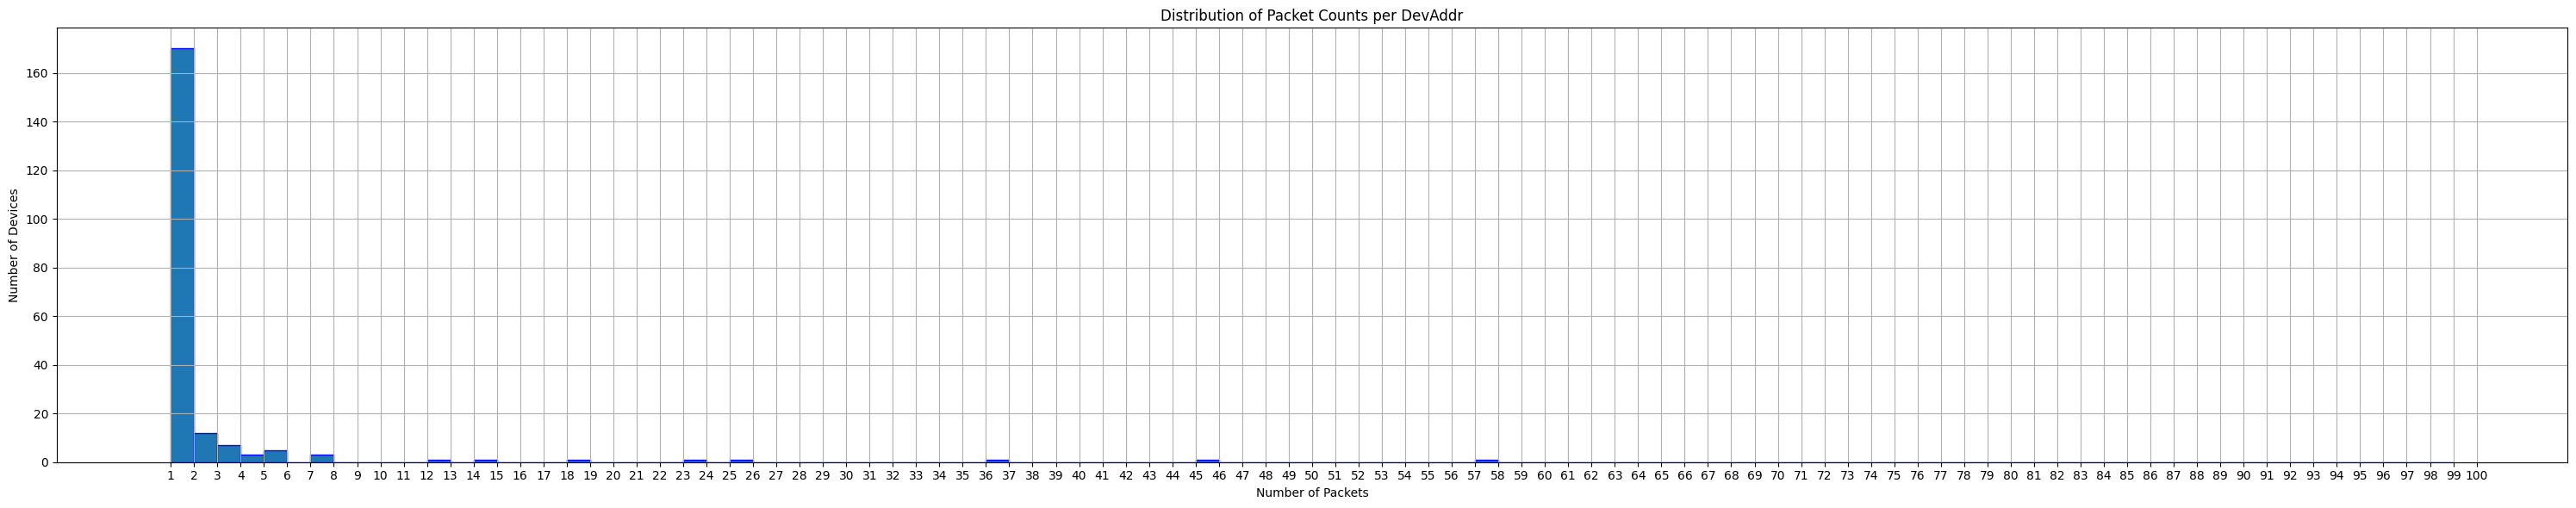

In [21]:
# A close up histogram
plt.figure(figsize=(30, 6))
plt.hist(devaddr_counts, bins=range(1, 100), edgecolor='blue')
plt.title('Distribution of Packet Counts per DevAddr')
plt.xlabel('Number of Packets')
plt.ylabel('Number of Devices')
plt.grid(True)
plt.tight_layout()
plt.xticks(ticks=range(1, 101))
plt.show()

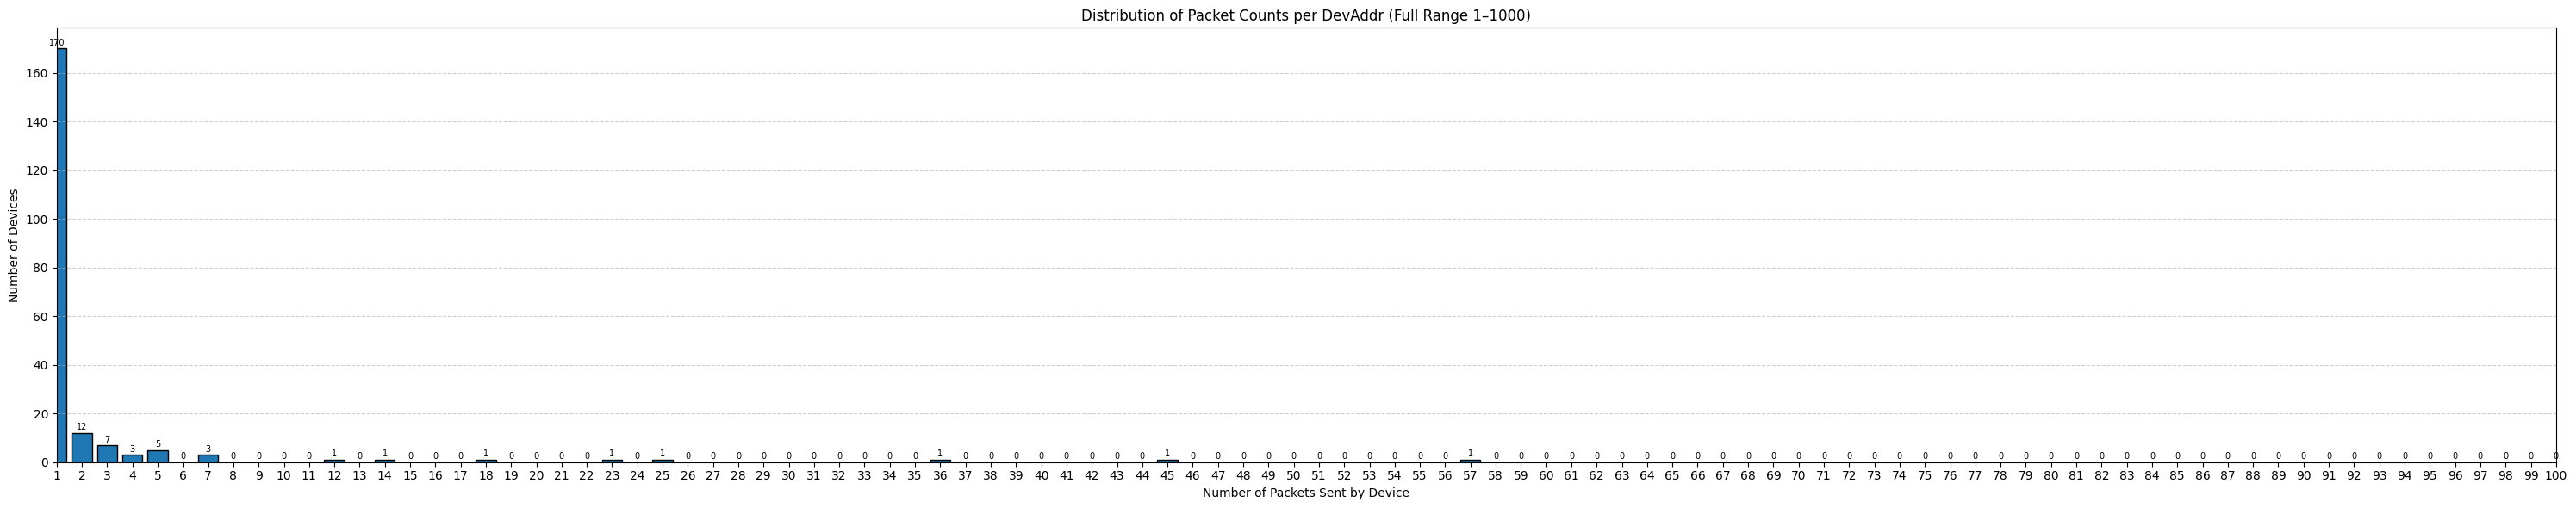

In [22]:
# Count how many devices sent X packets
packet_distribution = devaddr_counts.value_counts().sort_index()

# Ensure full x-axis from 1 to 1000
full_range = pd.Series(index=range(1, 101), dtype=int)
packet_distribution = packet_distribution.reindex(full_range.index, fill_value=0)

# Plot bar chart
plt.figure(figsize=(30, 6))
bars = plt.bar(packet_distribution.index, packet_distribution.values, edgecolor='black')

# Optionally add labels (skip if too crowded)
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
  ha='center', va='bottom', fontsize=7)

plt.title('Distribution of Packet Counts per DevAddr (Full Range 1–1000)')
plt.xlabel('Number of Packets Sent by Device')
plt.ylabel('Number of Devices')
plt.xlim(1, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.xticks(ticks=range(1, 101))
plt.show()

#SF Histogram

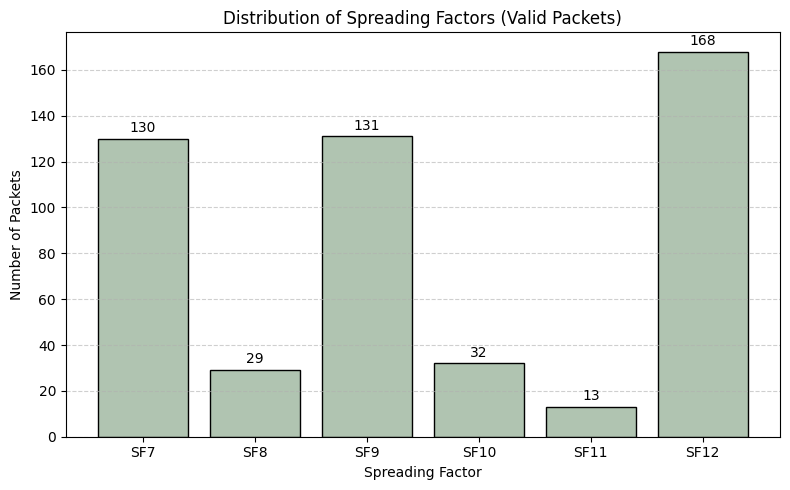

In [23]:
# Extract numeric SF
df_valid_packets['sf_num'] = df_valid_packets['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count, sort numerically, and relabel
sf_counts_valid = df_valid_packets['sf_num'].value_counts().sort_index()
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_valid.index]  # relabel x-axis

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(sf_labels, sf_counts_valid.values, color='#b0c4b1', edgecolor='black')
plt.title('Distribution of Spreading Factors (Valid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(sf_counts_valid.values) * 0.01,  # Slight vertical offset
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


# Per Device Loss Ratio
Loss Ratio= Total Expected Packets / Total Lost Packets

In [24]:
df.head()

,id,imme,tmst,tmms,freq,rfch,powe,modu,datr,codr,...,MHDR,MType,RFU,Major,DevAddr,FCtrl,FCnt,FOpts,FPort,FRMPayload
0,1,0,1729162410,Nan,868.3,0,14,LORA,SF9BW125,4/5,...,32,1,0,0,352d421f,136,956,73151a1b487a5f0c,139,4246254a2eaed906e0f0ac05d3f1493e
1,2,0,1729162418,Nan,867.9,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,0,0350ff000106,1,590c4e
2,3,0,1729162436,Nan,868.3,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,1,0351ff000106,39,344f9f
3,4,0,1729162454,Nan,868.1,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,2,0351ff000106,252,d9cf83
4,5,0,1729162472,Nan,868.3,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,3,0351ff000106,91,bb109b


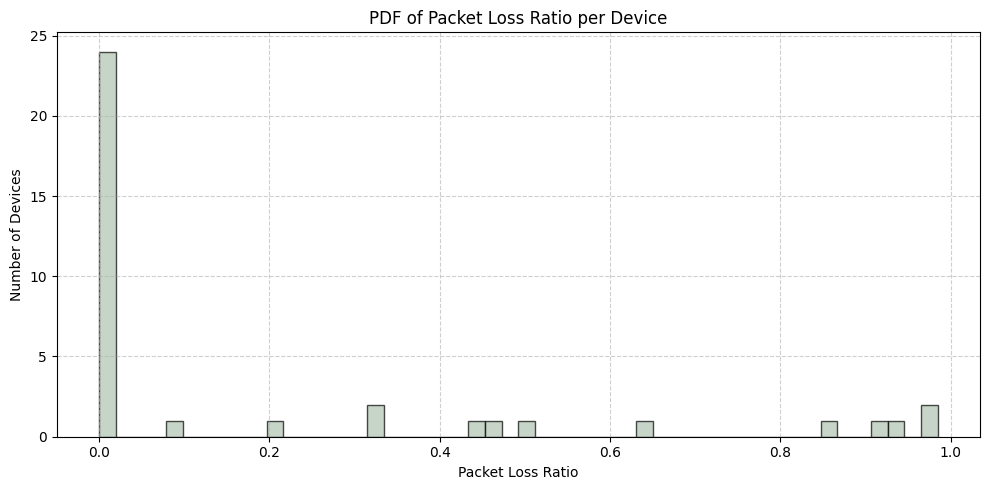

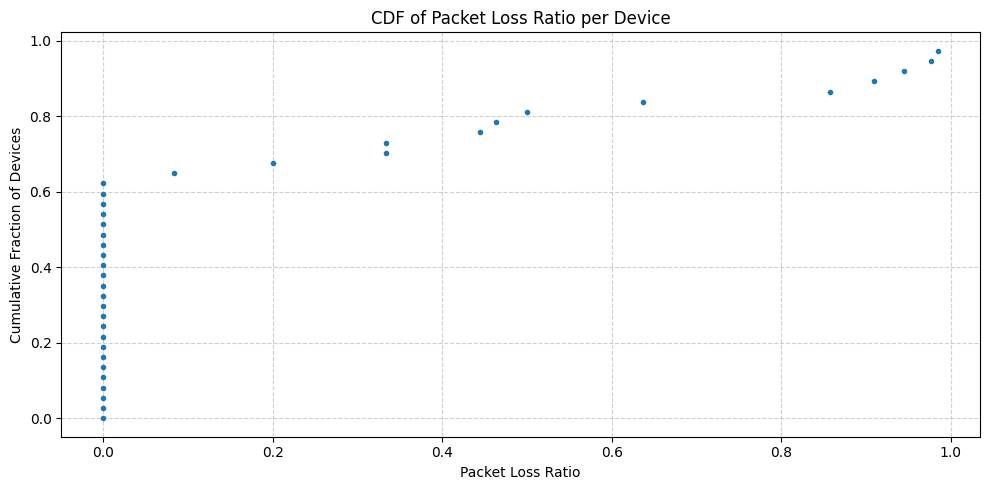

In [25]:
loss_ratios = []

# Group by DevAddr
for dev, group in df_valid_packets[['DevAddr', 'FCnt', 'tmst']].groupby('DevAddr'):
    group_sorted = group.sort_values(by='tmst')
    fcnts = group_sorted['FCnt'].values
    fcnt_diffs = np.diff(fcnts)

    # Lost packets calculation
    lost_packets = np.sum(fcnt_diffs[fcnt_diffs > 1] - 1)
    total_expected = fcnts[-1] - fcnts[0]

    if total_expected > 0:  # avoid divide by zero
        loss_ratio = lost_packets / total_expected
        loss_ratios.append(loss_ratio)

loss_ratios = np.array(loss_ratios)

# Plot PDF
plt.figure(figsize=(10, 5))
plt.hist(loss_ratios, bins=50, edgecolor='black', alpha=0.7, color='#b0c4b1')
plt.title('PDF of Packet Loss Ratio per Device')
plt.xlabel('Packet Loss Ratio')
plt.ylabel('Number of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot CDF
plt.figure(figsize=(10, 5))
sorted_ratios = np.sort(loss_ratios)
cdf = np.arange(len(sorted_ratios)) / len(sorted_ratios)
plt.plot(sorted_ratios, cdf, marker='.', linestyle='none')
plt.title('CDF of Packet Loss Ratio per Device')
plt.xlabel('Packet Loss Ratio')
plt.ylabel('Cumulative Fraction of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Network Wide Loss Rate
NC = uplink packets correctly received
NL = lost packets
lost= NL / (NC + NL)

In [26]:
total_lost = 0
total_received = 0

for dev, group in df.dropna(subset=['DevAddr', 'FCnt']).groupby('DevAddr'):
    group_sorted = group.sort_values(by='tmst')
    fcnts = group_sorted['FCnt'].values

    if len(fcnts) < 2:
        continue  # Not enough data

    fcnt_diffs = np.diff(fcnts)
    lost = np.sum(fcnt_diffs[fcnt_diffs > 1] - 1)
    received = len(fcnts)

    total_lost += lost
    total_received += received

# Network-wide loss rate
total_expected = total_lost + total_received
loss_ratio = total_lost / total_expected
total_lost

print(f"Network-wide packet loss rate: {loss_ratio:.6f}")

Network-wide packet loss rate: 0.915547


# Time analysis

In [27]:
from datetime import datetime

In [28]:
df_valid_packets['tmst_str'] = df_valid_packets['tmst'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_valid_packets['tmst_str']

0      2024-10-17 10:53:30
1      2024-10-17 10:53:38
2      2024-10-17 10:53:56
3      2024-10-17 10:54:14
4      2024-10-17 10:54:32
              ...         
498    2025-05-13 17:20:51
499    2025-05-14 20:55:00
500    2025-05-14 20:55:08
501    2025-05-14 20:55:17
502    2025-05-14 20:55:18
Name: tmst_str, Length: 503, dtype: object

In [29]:
print(df_valid_packets.tmst_str.max())
print(df_valid_packets.tmst_str.min())

2025-05-14 20:55:18
2024-10-17 10:53:30


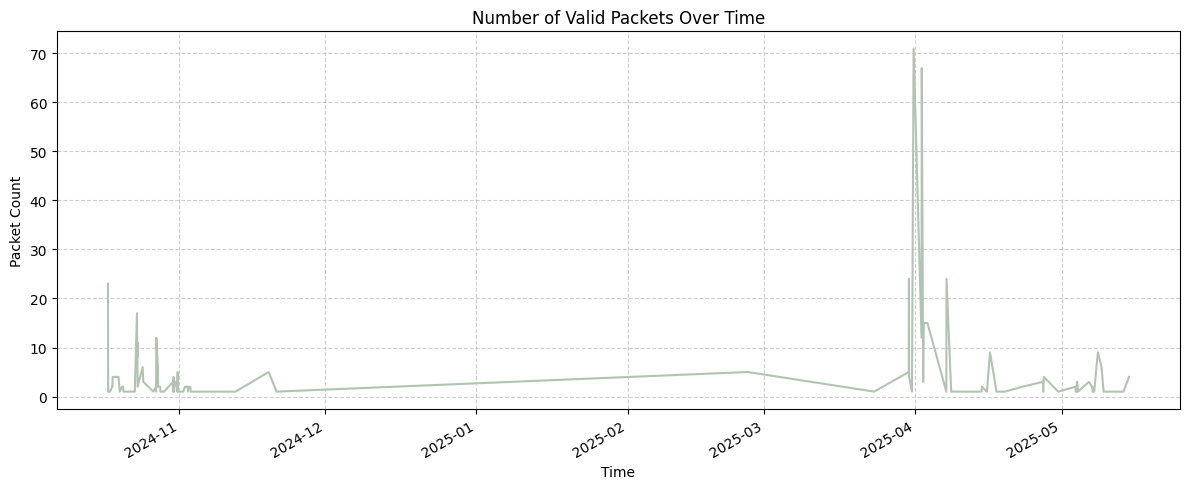

In [30]:
# Convert tmst_str back to datetime type
df_valid_packets['tmst_datetime'] = pd.to_datetime(df_valid_packets['tmst_str'], format='%Y-%m-%d %H:%M:%S')

# Get hourly info
df_valid_packets['time_bin'] = df_valid_packets['tmst_datetime'].dt.floor('1H')  # group by hour

# Count packets per time bin
packet_counts = df_valid_packets.groupby('time_bin').size()

plt.figure(figsize=(12, 5))
packet_counts.plot(kind='line', color="#b0c4b1")
plt.title('Number of Valid Packets Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()